## Attempting to replicate the results from:
# **CheXpert: A large chest radiograph dataset with uncertainty labels and expert comparison**
## https://arxiv.org/abs/1901.07031
##### Irvin, Jeremy and Rajpurkar, Pranav and Ko, Michael and Yu, Yifan and Ciurea-Ilcus, Silviana and Chute, Chris and Marklund, Henrik and Haghgoo, Behzad and Ball, Robyn and Shpanskaya, Katie and others

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from torchvision.models import *
import yaml
import pandas as pd
import datetime
import numpy as np

from sklearn.metrics import roc_auc_score

### Load configuration with local path and url for dataset

In [3]:
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
    path = cfg['path']

/home/trevor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [4]:
chestxrays_root = Path(path)
data_path = chestxrays_root

In [5]:
data_path

PosixPath('/media/trevor/main-storag')

### Load Data

In [6]:
full_train_df = pd.read_csv('/media/trevor/main-storag/CheXpert-v1.0-small/train.csv')
full_valid_df = pd.read_csv('/media/trevor/main-storag/CheXpert-v1.0-small/valid.csv')

In [7]:
chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

### Uncertainty Approaches

The CheXpert paper outlines several different approaches to mapping using the uncertainty labels in the data:

- Ignoring - essentially removing from the calculation in the loss function
- Binary mapping - sending uncertain values to either 0 or 1
- Prevalence mapping - use the rate of prevelance of the feature as it's target value
- Self-training - consider the uncertain values as unlabeled
- 3-Class Classification - retain a separate value for uncertain and try to predict it as a class in its own right


The paper gives the results of different experiments with the above approaches and indicates the most accurate approach for each feature.
    
|Approach/Feature|Atelectasis|Cardiomegaly|Consolidation|Edema|PleuralEffusion|
|-----------|-----------|-----------|-----------|-----------|-----------|
|`U-Ignore`|0.818(0.759,0.877)|0.828(0.769,0.888)|0.938(0.905,0.970)|0.934(0.893,0.975)|0.928(0.894,0.962)|
|`U-Zeros`|0.811(0.751,0.872)|0.840(0.783,0.897)|0.932(0.898,0.966)|0.929(0.888,0.970)|0.931(0.897,0.965)|
|`U-Ones`|**0.858(0.806,0.910)**|0.832(0.773,0.890)|0.899(0.854,0.944)|0.941(0.903,0.980)|0.934(0.901,0.967)|
|`U-Mean`|0.821(0.762,0.879)|0.832(0.771,0.892)|0.937(0.905,0.969)|0.939(0.902,0.975)|0.930(0.896,0.965)|
|`U-SelfTrained`|0.833(0.776,0.890)|0.831(0.770,0.891)|0.939(0.908,0.971)|0.935(0.896,0.974)|0.932(0.899,0.966)|
|`U-MultiClass`|0.821(0.763,0.879)|**0.854(0.800,0.909)**|0.937(0.905,0.969)|0.928(0.887,0.968)|0.936(0.904,0.967)|

The binary mapping approaches (U-Ones and U-Zeros) are easiest to implement and so to begin with we take the best option between U-Ones and U-Zeros for each feature

- Atelectasis `U-Ones`
- Cardiomegaly `U-Zeros`
- Consolidation `U-Zeros`
- Edema `U-Ones`
- Pleural Effusion `U-Zeros`

We will use u-multiclasses in this attempt. So we re-define the classes as: 

In [8]:
# u_one_features = ['Atelectasis', 'Edema']
# u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
u_targets = ['Atelectasis_u', 'Cardiomegaly_u', 'Consolidation_u', 'Edema_u', 'Pleural Effusion_u']
p_targets = ['Atelectasis_p', 'Cardiomegaly_p', 'Consolidation_p', 'Edema_p', 'Pleural Effusion_p']
n_targets = ['Atelectasis_n', 'Cardiomegaly_n', 'Consolidation_n', 'Edema_n', 'Pleural Effusion_n']
u_multi_targets = u_targets + p_targets + n_targets

### Add target features string

In [9]:
# Determine the labels of the sample
def feature_string(row):
    feature_list = []
    for feature in chexpert_targets:
        # if 1 then has the feature
        if row[feature] == 1:
            feature_list.append(feature+'_p')
        # if -1 then add ''_u to the feature
        elif row[feature] == -1:
            feature_list.append(feature+'_u')
        elif row[feature] == 0:
            feature_list.append(feature+'_n')
            
    return ';'.join(feature_list)

In [10]:
full_train_df['train_valid'] = False
full_valid_df['train_valid'] = True

##### Create patient and study columns

In [11]:
full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
full_train_df  ['study'] = full_train_df.Path.str.split('/',4,True)[3]

full_valid_df['patient'] = full_valid_df.Path.str.split('/',3,True)[2]
full_valid_df  ['study'] = full_valid_df.Path.str.split('/',4,True)[3]

In [12]:
full_df = pd.concat([full_train_df, full_valid_df])
full_df = full_df.reset_index(drop=True)

In [13]:
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

### Set up a small sample for fast iteration

In [14]:
def get_sample_df(sample_perc = 0.05):
    np.random.seed(99)
    
    train_only_df = full_df[~full_df.train_valid]
    valid_only_df = full_df[full_df.train_valid]
    unique_patients = train_only_df.patient.unique()
    mask = np.random.rand(len(unique_patients)) < sample_perc
    sample_patients = unique_patients[mask]

    sample_df = train_only_df[full_train_df.patient.isin(sample_patients)]
    return pd.concat([sample_df,valid_only_df])

### Set up data set using Fastai datablock

In [15]:
def get_src(df = full_df):
    return (ImageList
        .from_df(df, data_path, 'Path')
        .split_from_df('train_valid')
        .label_from_df('feature_string',label_delim=';')
       )

In [16]:
def get_data(size, src, bs=32):
    return (src.transform(get_transforms(do_flip=False), size=size, padding_mode='zeros')
        .databunch(bs=bs).normalize(imagenet_stats))

## Create a function to evaluate performance of all features

In [17]:
def get_preds_per_study():
    valid_preds=learn.get_preds(ds_type=DatasetType.Valid)[0]
   
    for i, c in enumerate(learn.data.classes):
        full_valid_df[c] = valid_preds[:,i]
    
    return full_valid_df.groupby(['patient','study'])[learn.data.classes].max().reset_index()

In [18]:
# def validation_eval(learn):
#     acts = full_valid_df.groupby(['patient','study'])[learn.data.classes].max().values

#     valid_preds=learn.get_preds(ds_type=DatasetType.Valid)
#     preds = valid_preds[0]
#     preds_df = full_valid_df.copy()

#     for i, c in enumerate(learn.data.classes):
#         preds_df[c] = preds[:,i]

#     preds = preds_df.groupby(['patient','study'])[learn.data.classes].max().values

#     auc_scores = {data.classes[i]: roc_auc_score(acts[:,i],preds[:,i]) for i in range(len(chexpert_targets))}

#     #average results reported in the associated paper
#     chexpert_auc_scores = {'Atelectasis':      0.858,
#                            'Cardiomegaly':     0.854,
#                            'Consolidation':    0.939,
#                            'Edema':            0.941,
#                            'Pleural Effusion': 0.936}

#     max_feat_len = max(map(len, chexpert_targets))

#     avg_chexpert_auc = sum(list(chexpert_auc_scores.values()))/len(chexpert_auc_scores.values())
#     avg_auc          = sum(list(auc_scores.values()))/len(auc_scores.values())

#     [print(f'{k: <{max_feat_len}}\t auc: {auc_scores[k]:.3}\t chexpert auc: {chexpert_auc_scores[k]:.3}\t difference:\
#     {(chexpert_auc_scores[k]-auc_scores[k]):.3}') for k in chexpert_targets]

#     print(f'\nAverage auc: {avg_auc:.3} \t CheXpert average auc {avg_chexpert_auc:.3}\t Difference {(avg_chexpert_auc-avg_auc):.3}')
    
#     return avg_auc

In [19]:
def get_df_onehot(df):
    for c in u_targets:
        df[c] = [None]*len(df)
    for idx,r in df.iterrows():
        for c in chexpert_targets:
            if r[c] == -1:
                df.loc[idx,c] = None
                df.loc[idx,c+'_u'] = 1
                df.loc[idx,c+'_p'] = 0
                df.loc[idx,c+'_n'] = 0
            elif r[c] == 1:
                df.loc[idx,c] = None
                df.loc[idx,c+'_u'] = 0
                df.loc[idx,c+'_p'] = 1
                df.loc[idx,c+'_n'] = 0
            elif r[c] == 0:
                df.loc[idx,c] = None
                df.loc[idx,c+'_u'] = 0
                df.loc[idx,c+'_p'] = 0
                df.loc[idx,c+'_n'] = 1
            else:
                df.loc[idx,c] = None
                df.loc[idx,c+'_u'] = 0
                df.loc[idx,c+'_p'] = 0
                df.loc[idx,c+'_n'] = 0
    return df

In [20]:
def validation_eval(learn):
    # unlike using u_1 and u_0, we need extra classes for binary auc_roc_score
    # we will using similiar strategy as 'one_hot_encoding'
    acts = get_df_onehot(full_valid_df)
    
    # model_classes_pred = [x for x in learn.data.classes if x in chexpert_targets]
    acts = full_valid_df.groupby(['patient','study'])[learn.data.classes].max().values

    valid_preds=learn.get_preds(ds_type=DatasetType.Valid)
    preds = valid_preds[0]
    preds_df = full_valid_df.copy()

    for i, c in enumerate(learn.data.classes):
        preds_df[c] = preds[:,i]

    preds = preds_df.groupby(['patient','study'])[learn.data.classes].max().values
    
    auc_scores = {}
    
    for i in range(len(learn.data.classes)):
        # handel only one class case
        try:
            score = roc_auc_score(acts[:,i],preds[:,i])
        except ValueError:
            n_acts = acts[:,i]
            n_acts = np.append(n_acts,0)
            n_acts = np.append(n_acts,1)
            n_preds = preds[:,i]
            n_preds = np.append(n_preds,0)
            n_preds = np.append(n_preds,1)
            print(n_acts)
            score = roc_auc_score(n_acts,n_preds)
        auc_scores[learn.data.classes[i]] = score
    print(auc_scores)

#     #average results reported in the associated paper
#     chexpert_auc_scores = {'Atelectasis':      0.858,
#                            'Cardiomegaly':     0.854,
#                            'Consolidation':    0.939,
#                            'Edema':            0.941,
#                            'Pleural Effusion': 0.936}

#     max_feat_len = max(map(len, chexpert_targets))

#     avg_chexpert_auc = sum(list(chexpert_auc_scores.values()))/len(chexpert_auc_scores.values())
    avg_auc = sum(list(auc_scores.values()))/len(auc_scores.values())

    [print(f'auc: {auc_scores[k]:.3}\t') for k in u_multi_targets]

    print(f'\nAverage auc: {avg_auc:.3} \t')
    
    return avg_auc

### Create callbacks to evaluate and save learner

In [21]:
class CheXpertEvalCallback(LearnerCallback):
    def __init__(self, learn):
        super().__init__(learn)
        self.skip = False
        self.avg_auc = 0
    def on_epoch_end(self,**kwargs):
        if self.skip: return
        # Here to change for another evaluation model
        self.avg_auc = validation_eval(self.learn)

In [22]:
class SaveCallback(LearnerCallback):
    _order = 99
    def __init__(self, learn):
        super().__init__(learn)
        self.epoch = 0
        self.skip = False
    def on_epoch_end(self, **kwargs):
        self.epoch += 1
        if self.skip: return
        learn.save(f'{datetime.datetime.now():%Y-%m-%d %H:%M} AUC:{self.che_xpert_eval_callback.avg_auc:.3}')

In [23]:
cbfs = [CheXpertEvalCallback, SaveCallback]

### Alter LR_Finder to remove my callbacks before running

In [24]:
def lr_find_no_cbs(learn):
    learn.callback_fns = [cbf for cbf in learn.callback_fns if cbf not in cbfs]
    lr_find(learn)
    learn.recorder.plot(suggestion=True)
    learn.callback_fns += cbfs

### Train on full set with image size 224

In [25]:
img_size = 224
data = get_data(img_size, get_src(full_df))
learn = cnn_learner(data, densenet121, callback_fns=cbfs)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


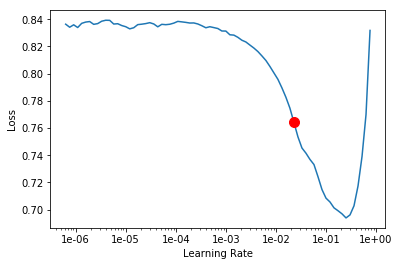

In [26]:
lr_find_no_cbs(learn)

In [27]:
lr=1e-2
learn.fit_one_cycle(1,slice(lr))

[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
{'Atelectasis_n': 0.7019733333333334, 'Atelectasis_p': 0.7498666666666667, 'Atelectasis_u': 1.0, 'Cardiomegaly_n': 0.7424242424242424, 'Cardiomegaly_p': 0.7856173677069199, 'Cardiomegaly_u': 1.0, 'Consolidation_n': 0.8863467261904762, 'Consolidation_p': 0.8474702380952381, 'Consolidation_u': 1.0, 'Edema_n': 0.8220313441832429, 'Edema_p': 0.9109403254972875, 'Edema_u': 1.0, 'Pleural Effusion_n': 0.8622472426470588, 'Pleural Effusion_p': 0.9021139705882353, 'Pleural Effusion_u': 1.0}
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 0.75	
auc: 0.786	
auc: 0.847	
auc: 0.911	
auc: 0.902	
auc: 0.702	
auc: 0.742	
auc: 0.886	
auc: 0.822	
auc: 0.862	

Average auc: 0.881 	


In [28]:
# learn.export(Path('/media/trevor/main-storag/master_classes/big_data_health/BDH_project')/'models'/'u_multiclass.pkl')
learn.save('/media/trevor/main-storag/master_classes/big_data_health/BDH_project/models/u_multiclass')

### Train on sample set with image size 224

In [54]:
img_size = 224
data = get_data(img_size, get_src(get_sample_df(0.02)), bs=40)
learn = cnn_learner(data, densenet121, callback_fns=cbfs)

In [55]:
# Don't know what this is for...
# learn.load('blah');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


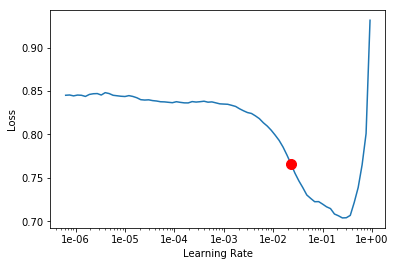

In [56]:
lr_find_no_cbs(learn)

In [50]:
lr = 5e-5
learn.fit_one_cycle(1,slice(lr))

[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
[0. 0. 0. 0. ... 0. 0. 0. 1.]
{'Atelectasis_n': 1.0, 'Atelectasis_p': 1.0, 'Atelectasis_u': 1.0, 'Cardiomegaly_n': 1.0, 'Cardiomegaly_p': 1.0, 'Cardiomegaly_u': 1.0, 'Consolidation_n': 1.0, 'Consolidation_p': 1.0, 'Consolidation_u': 1.0, 'Edema_n': 1.0, 'Edema_p': 1.0, 'Edema_u': 1.0, 'Pleural Effusion_n': 1.0, 'Pleural Effusion_p': 1.0, 'Pleural Effusion_u': 1.0}
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	
auc: 1.0	

Average auc: 1.0 	


In [40]:
!nvidia-smi

Sat Apr 13 16:19:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  7%   50C    P2    51W / 215W |   2150MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Export entire model

In [ ]:
# if learn is None:
#     learn = load_learner(data_path/'models','naive_densenet.pkl')
# else:
#     full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
#     learn.export(data_path/'models'/'size_{img_size}_auc_{self.avg_auc}_{datetime.datetime.now(): "%Y-%m-%d %H:%M"}.pkl')

### Things to try to improve score

- Building more sophisticated model structure to account for unknowns
- Curriculum learning
- Mixup
- Use the labelling tool from the ChexPert paper : https://github.com/stanfordmlgroup/chexpert-labeler